In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import colorcet as cc
import plotly.express as px

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
%matplotlib inline

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'newplot',
    'height': 500,
    'width': 900,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

In [2]:
df=pd.read_pickle('./dataset_/dataset_cleaned_popularity.pkl')
df.drop(columns=['index', 'level_0'], inplace=True)  # Comes from pickeling the file
df.reset_index(drop=True, inplace=True)

In [3]:
df['popularity'].describe()

count    166681.000000
mean       5511.366120
std       13236.831027
min           0.800000
25%          78.400000
50%         530.400000
75%        3995.050000
max      233766.900000
Name: popularity, dtype: float64

## Popularity Prediction
This week, we started to work on our predictive mining tasks, one of them is song popularity prediction. By the end of this project, we hope that we can see what is the typical song that is getting more popular than the others in Spotify. We got two ideas in mind, which are popularity score prediction and popularity classification (popular / not popular).

### Data Pre-processing
Before jump into the main modelling task, here we'll process all of our our possible features based on its data type:

**Numerical Features**
* popularity
* artist_followers
* danceability
* energy
* loudness
* speechiness
* acoustics
* instrumentalness
* liveness
* valence
* duration_min

**Categorical Features**
* explicit
* key
* mode
* release_day

For the first round selection, we selected the features based on our knowledge and common sense, later we'll try to fit in all these features into some models first and see how they perform.
#### Popularity
The original value of our popularity score is the calculation of number of days and position they stayed in the Top 200 Playlist and the score is also difference for each country.

In [4]:
df.sort_values(by='popularity', ascending=False).head(5)

,country,uri,popularity,title,artist,release_type,sub_genre,artist_followers,explicit,album,release_date,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,days_since_release,released_after_2017,explicit_false,explicit_true,popu_max,top10_dummy,top50_dummy,cluster,duration_min,release_year,release_month,release_day
52226,Belgium,https://open.spotify.com/track/7qiZfU4dY1lWllz...,233766.9,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,english speaking and nordic,3.895217,2017,3,3
52232,Costa Rica,https://open.spotify.com/track/7qiZfU4dY1lWllz...,228707.2,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,spanish speaking,3.895217,2017,3,3
52220,Global,https://open.spotify.com/track/7qiZfU4dY1lWllz...,221571.0,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,global,3.895217,2017,3,3
30287,Philippines,https://open.spotify.com/track/5uCax9HTNlzGybI...,217605.8,say you wont let go,James Arthur,album,pop,6843219.0,False,Back from the Edge,2016-10-28,2,17,0.358,0.557,10,-7.398,1,0.0590,0.695,0.0,0.0902,0.494,85.043,4,pop,1469.0,0.0,1,0,2,1.0,1.0,southern europe and portuguese heritage,3.524450,2016,10,28
52252,Singapore,https://open.spotify.com/track/7qiZfU4dY1lWllz...,217307.4,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,english speaking and nordic,3.895217,2017,3,3


As you can see in the table, there are multiple countries that have "Shape of You" as their top popular song, and this also means that this song is very popular compared to a song that only appears in one coutnry top playlist, right?

So, in order to get a unique song popularity score, we decided to sum up the every country's popularity score for each song, since the higher value they got, means the more popular they are.

In [5]:
# df = df.groupby(['title', 'artist', 'release_type', 'sub_genre', 'artist_followers', 'explicit', 'album', 'track_number', 'tracks_in_album', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acoustics', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'genre', 'duration_min', 'release_year', 'release_month', 'release_day'])['popularity'].sum().reset_index(name='popularity')
df = df[df['country'] == 'Global']
df.sort_values(by='popularity', ascending=False).head(5)

,country,uri,popularity,title,artist,release_type,sub_genre,artist_followers,explicit,album,release_date,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,days_since_release,released_after_2017,explicit_false,explicit_true,popu_max,top10_dummy,top50_dummy,cluster,duration_min,release_year,release_month,release_day
52220,Global,https://open.spotify.com/track/7qiZfU4dY1lWllz...,221571.00,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.000000,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,global,3.895217,2017,3,3
59759,Global,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,157270.00,dance monkey,Tones And I,single,australian pop,2283019.0,False,Dance Monkey,2019-05-10,1,1,0.825,0.593,6,-6.401,0,0.0988,0.688,0.000161,0.1700,0.540,98.078,4,pop,554.0,1.0,1,0,1,1.0,1.0,global,3.495917,2019,5,10
82857,Global,https://open.spotify.com/track/2Fxmhks0bxGSBdJ...,130062.25,bad guy,Billie Eilish,album,electropop,34697267.0,False,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2019-03-29,2,14,0.701,0.425,7,-10.965,1,0.3750,0.328,0.130000,0.1000,0.562,135.128,4,pop,596.0,1.0,1,0,1,1.0,1.0,global,3.234800,2019,3,29
14124,Global,https://open.spotify.com/track/0tgVpDi06FyKpA1...,129769.90,perfect,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,5,16,0.599,0.448,8,-6.312,1,0.0232,0.163,0.000000,0.1060,0.168,95.050,3,pop,1349.0,1.0,1,0,3,1.0,1.0,global,4.390000,2017,3,3
70886,Global,https://open.spotify.com/track/2VxeLyX666F8uXC...,111896.05,shallow,Lady Gaga - Bradley Cooper,album,dance pop,14439685.0,False,A Star Is Born Soundtrack,2018-10-05,12,34,0.572,0.385,7,-6.362,1,0.0308,0.371,0.000000,0.2310,0.323,95.799,4,pop,771.0,1.0,1,0,2,1.0,1.0,global,3.595550,2018,10,5


As a result, we got 59,492 unique songs.

The mean is way too shifted to the left, even from 59k songs, 51k songs are below average, because the dataset has a few extreme popular songs. But it's not possible to enrich the data again, because the calculation of popularity in our dataset is different between the Spotify one. Consequently, we'll work on the data as it is.

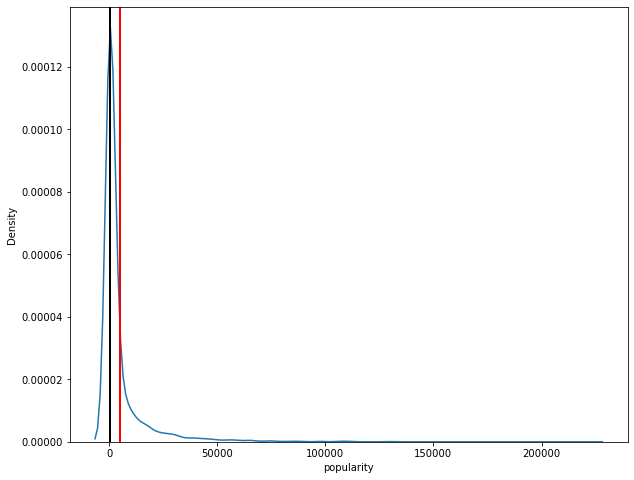

In [6]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df['popularity'])

plt.axvline(df['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

After that, we checked again which feature is needed to be processed.

In [7]:
df.nunique(axis=0)

country                   1
uri                    5423
popularity             3745
title                  4530
artist                 2573
release_type              3
sub_genre               256
artist_followers        963
explicit                  2
album                  2988
release_date           1039
track_number             32
tracks_in_album          47
danceability            705
energy                  804
key                      12
loudness               3814
mode                      2
speechiness            1141
acoustics              1930
instrumentalness       1588
liveness               1035
valence                1003
tempo                  4666
time_signature            4
genre                    18
days_since_release     1036
released_after_2017       2
explicit_false            2
explicit_true             2
popu_max                200
top10_dummy               2
top50_dummy               2
cluster                   1
duration_min           4764
release_year        

From the result above, you can see that explicit and mode is supposed to have only binary value, but there is 4 unique values instead.

#### Explicit
We will change the string value of "True" and "False" into a boolean one.

In [8]:
df['explicit'].unique()

array([False, True], dtype=object)

In [9]:
df.loc[df.explicit == 'True', 'explicit'] = 1
df.loc[df.explicit == 'False', 'explicit'] = 0
df.loc[df.explicit == True, 'explicit'] = 1
df.loc[df.explicit == False, 'explicit'] = 0

In [10]:
df['explicit'].unique()

array([0, 1], dtype=object)

#### Mode
We will change the string value of "0" and "1" into a numeric one.

In [11]:
df['mode'].unique()

array([1, 0], dtype=object)

In [12]:
df.loc[df['mode'] == '0', 'mode'] = 0
df.loc[df['mode'] == '1', 'mode'] = 1

In [13]:
df['mode'].unique()

array([1, 0], dtype=object)

In [14]:
df.nunique(axis=0)

country                   1
uri                    5423
popularity             3745
title                  4530
artist                 2573
release_type              3
sub_genre               256
artist_followers        963
explicit                  2
album                  2988
release_date           1039
track_number             32
tracks_in_album          47
danceability            705
energy                  804
key                      12
loudness               3814
mode                      2
speechiness            1141
acoustics              1930
instrumentalness       1588
liveness               1035
valence                1003
tempo                  4666
time_signature            4
genre                    18
days_since_release     1036
released_after_2017       2
explicit_false            2
explicit_true             2
popu_max                200
top10_dummy               2
top50_dummy               2
cluster                   1
duration_min           4764
release_year        

#### Key
There are duplicated keys, so we tried to convert all of them into numeric values.

In [15]:
df['key'].unique()

array([1, 6, 2, 7, 8, 10, 0, 4, 11, 9, 5, 3], dtype=object)

In [16]:
df.loc[df['key'] == '9', 'key'] = 9
df.loc[df['key'] == '10', 'key'] = 10
df.loc[df['key'] == '0', 'key'] = 0
df.loc[df['key'] == '5', 'key'] = 5
df.loc[df['key'] == '11', 'key'] = 11
df.loc[df['key'] == '4', 'key'] = 4
df.loc[df['key'] == '7', 'key'] = 7
df.loc[df['key'] == '2', 'key'] = 2
df.loc[df['key'] == '3', 'key'] = 3
df.loc[df['key'] == '6', 'key'] = 6
df.loc[df['key'] == '8', 'key'] = 8
df.loc[df['key'] == '1', 'key'] = 1

In [17]:
df['key'].unique()

array([1, 6, 2, 7, 8, 10, 0, 4, 11, 9, 5, 3], dtype=object)

#### Release Day

In [18]:
df['release_date'] = pd.to_datetime(df['release_year'].astype(str) + '-' + df['release_month'].astype(str) + '-' + df['release_day'].astype(str), errors='ignore')
df['weekday'] = df['release_date'].dt.dayofweek
df

,country,uri,popularity,title,artist,release_type,sub_genre,artist_followers,explicit,album,release_date,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,days_since_release,released_after_2017,explicit_false,explicit_true,popu_max,top10_dummy,top50_dummy,cluster,duration_min,release_year,release_month,release_day,weekday
0,Global,https://open.spotify.com/track/6FyRXC8tJUh863J...,31833.95,adan y eva,Paulo Londra,single,argentine hip hop,11427104.0,0,Adan y Eva,2018-11-05,1,1,0.767,0.709,1,-4.470,1,0.3360,0.323000,0.000000,0.0676,0.720,171.993,4,hip hop,740.0,1.0,1,0,10,1.0,1.0,global,4.310650,2018,11,5,0
16,Global,https://open.spotify.com/track/5xhJmd0I15jFcEd...,418.00,it wont kill ya,The Chainsmokers - Louane,album,dance pop,16931568.0,0,Memories...Do Not Open,2017-04-07,7,12,0.572,0.530,6,-8.521,0,0.0654,0.064700,0.000169,0.1270,0.120,170.138,4,pop,1314.0,1.0,1,0,72,0.0,0.0,global,3.626883,2017,4,7,4
39,Global,https://open.spotify.com/track/0wJJhRgdHhT93Z3...,56.00,hymn,Kesha,single,dance pop,5910376.0,1,Hymn,2017-08-03,1,1,0.488,0.538,6,-4.974,1,0.0760,0.147000,0.000000,0.3050,0.380,67.037,4,pop,1199.0,1.0,0,1,131,0.0,0.0,global,3.426667,2017,8,3,3
58,Global,https://open.spotify.com/track/6JSryEdVJTZq6YB...,78.40,arrows,Foo Fighters,album,alternative metal,8092392.0,0,Concrete and Gold,2017-09-15,7,11,0.515,0.917,1,-7.312,1,0.0417,0.000209,0.000476,0.1450,0.409,121.988,4,metal,1156.0,1.0,1,0,103,0.0,0.0,global,4.436450,2017,9,15,4
80,Global,https://open.spotify.com/track/7nAfXgeHfDO50up...,244.95,talking to myself,Linkin Park,album,alternative metal,17132813.0,0,One More Light,2017-05-19,3,10,0.593,0.712,2,-6.325,0,0.0286,0.001840,0.000000,0.1280,0.473,124.013,4,metal,1272.0,1.0,1,0,86,0.0,0.0,global,3.855117,2017,5,19,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83257,Global,https://open.spotify.com/track/1rIKgCH4H52lrvD...,1896.00,lush life,Zara Larsson,album,dance pop,7920553.0,0,So Good,2017-03-17,2,15,0.694,0.712,7,-3.923,0,0.0460,0.133000,0.000000,0.2110,0.799,98.022,4,pop,1335.0,1.0,1,0,104,0.0,0.0,global,3.352033,2017,3,17,4
83289,Global,https://open.spotify.com/track/6f3Slt0GbA2bPZl...,141.60,the business,Tiësto,single,big room,5177309.0,0,The Business,2020-09-16,1,1,0.798,0.620,8,-7.079,0,0.2320,0.414000,0.019200,0.1120,0.235,120.031,4,house,59.0,1.0,1,0,160,0.0,0.0,global,2.733333,2020,9,16,2
83302,Global,https://open.spotify.com/track/1xndOD8CreR5ctk...,672.25,scooby doo pa pa,Dj Kass,single,chilean hardcore,30456.0,0,Scooby Doo Pa Pa,2017-09-12,1,1,0.910,0.754,10,-2.573,0,0.2390,0.039600,0.001540,0.1220,0.630,120.939,4,dance/electronic,1159.0,1.0,1,0,88,0.0,0.0,global,2.432867,2017,9,12,1
83308,Global,https://open.spotify.com/track/35mvY5S1H3J2QZy...,3713.40,positions,Ariana Grande,album,dance pop,52571724.0,1,Positions,2020-10-30,12,14,0.737,0.802,0,-4.771,1,0.0878,0.468000,0.000000,0.0931,0.682,144.015,4,pop,15.0,1.0,0,1,1,1.0,1.0,global,2.872083,2020,10,30,4


In [19]:
df['weekday'].unique()

array([0, 4, 3, 2, 1, 6, 5])

#### Drop Unused Columns

In [20]:
categorical_features = ["title", 
                        "artist", 
                        "sub_genre", 
                        "album", 
                        "track_number", 
                        "tracks_in_album", 
                        "time_signature", 
                        "genre"]

In [21]:
numeric_features = ['popularity', 'artist_followers', 'danceability', 'energy', 
                    'loudness', 'speechiness', 'acoustics', 'instrumentalness', 
                    'liveness', 'valence', 'tempo', 'duration_min']

In [22]:
df_selected = df[numeric_features]

In [23]:
df_selected.nunique(axis=0)

popularity          3745
artist_followers     963
danceability         705
energy               804
loudness            3814
speechiness         1141
acoustics           1930
instrumentalness    1588
liveness            1035
valence             1003
tempo               4666
duration_min        4764
dtype: int64

### Features Visualization
Here we wanted to recap on how all the features behave in popularity and for a better visualization, we will scale the popularity values first into a 0-100 range.

In [24]:
df_scaled = df.copy()
df_scaled['popularity'] = (df_scaled['popularity'] - df_scaled['popularity'].min()) / (df_scaled['popularity'].max() - df_scaled['popularity'].min()) * 100

In [25]:
X = df_scaled['popularity'].values.reshape(-1,1)
df_scaled['popularity'] = QuantileTransformer(output_distribution="normal").fit_transform(X)

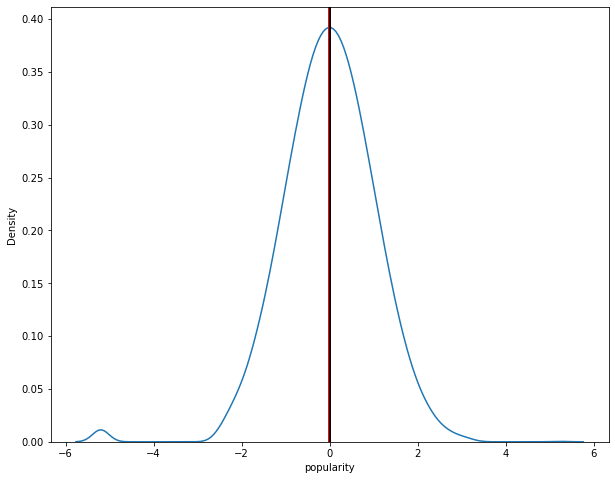

In [26]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df_scaled['popularity'])

plt.axvline(df_scaled['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df_scaled['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

In [27]:
df_scaled['popularity'] = (df_scaled['popularity'] - df_scaled['popularity'].min()) / (df_scaled['popularity'].max() - df_scaled['popularity'].min()) * 100

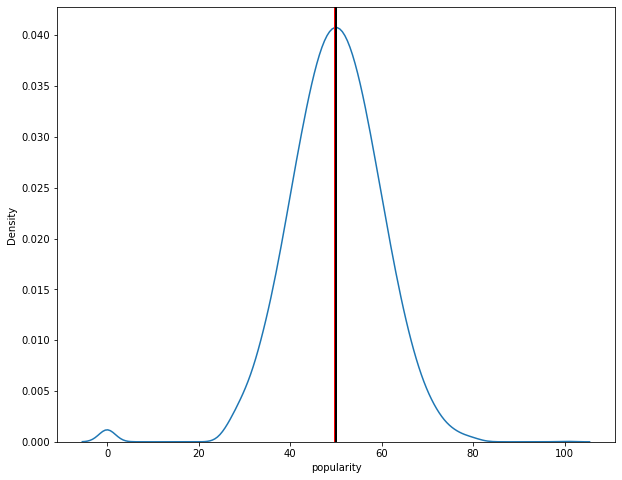

In [28]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df_scaled['popularity'])

plt.axvline(df_scaled['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df_scaled['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

<Figure size 1152x576 with 0 Axes>

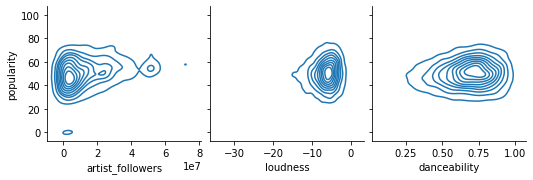

In [29]:
plt.figure(figsize=(16, 8))
sns.pairplot(data=df_scaled,
                  x_vars=['artist_followers', 'loudness', 'danceability'],
                  y_vars=['popularity'], kind="kde")
plt.show()

<Figure size 1152x576 with 0 Axes>

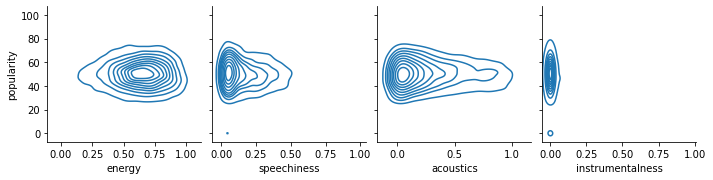

In [30]:
plt.figure(figsize=(16, 8))
sns.pairplot(data=df_scaled,
                  x_vars=['energy', 'speechiness', 'acoustics', 'instrumentalness'],
                  y_vars=['popularity'], kind="kde")
plt.show()

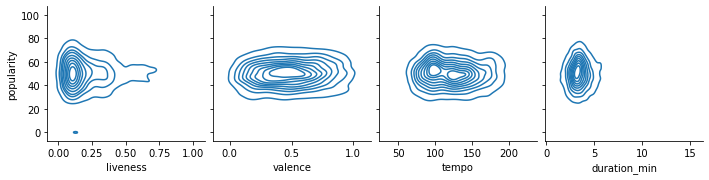

In [31]:
sns.pairplot(data=df_scaled,
                  x_vars=['liveness', 'valence', 'tempo', 'duration_min'],
                  y_vars=['popularity'], kind="kde")

### Modelling

In [32]:
y = df_selected['popularity']
X = df_selected.drop(["popularity"],axis=1)

#### 1. Linear Regression

First, we would like to see how our numerical features perform first.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

In [34]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)
train_pred = lm.predict(X_train)
test_pred = lm.predict(X_test)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

Test set evaluation:
_____________________________________
MAE: 6359.961746138566
MSE: 128376427.5868267
RMSE: 11330.332192253973
R2 Square 0.044329457839639375
__________________________________
Train set evaluation:
_____________________________________
MAE: 6287.137355624665
MSE: 146544565.52474362
RMSE: 12105.559281782218
R2 Square 0.04482676805922747
__________________________________


The lower value of MAE, MSE, and RMSE implies higher accuracy of a regression model. However, a higher value of R square is considered desirable.

R-squared is always between 0 and 100%:

- 0% represents a model that does not explain any of the variation in the response variable around its mean. The mean of the dependent variable predicts the dependent variable as well as the regression model.
- 100% represents a model that explains all the variation in the response variable around its mean.

So, if the R2 of a model is 0.50, then approximately half of the observed variation can be explained by the model’s inputs. And by our case, it's almost near zero, then the model doesn't represent the overall variance of the variables.

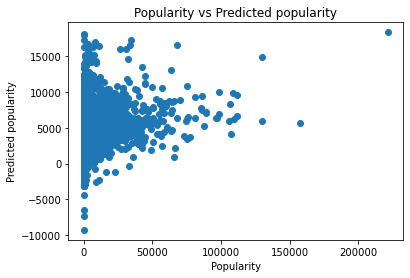

In [35]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, train_pred)
plt.xlabel("Popularity")
plt.ylabel("Predicted popularity")
plt.title("Popularity vs Predicted popularity")
plt.show()

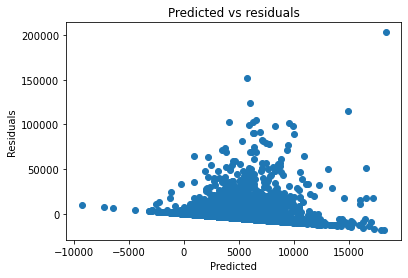

In [36]:
# Checking residuals
plt.scatter(train_pred,y_train-train_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

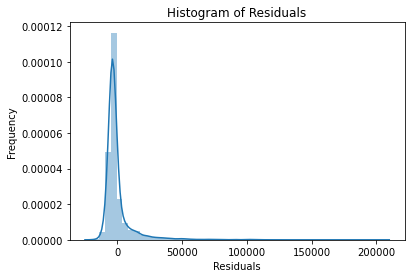

In [37]:
# Checking Normality of errors
sns.distplot(y_train-train_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

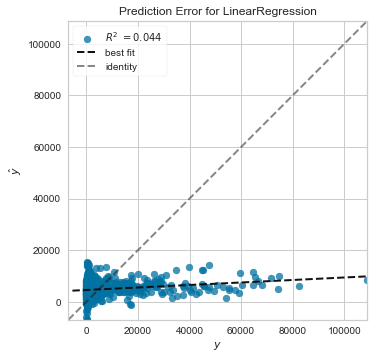

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [38]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(lm)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

#### 2. Random Forest Regressor

In [47]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 7083.630972506803
MSE: 144509930.01940042
RMSE: 12021.228307431833
R2 Square -0.07577291069102499
__________________________________
Train set evaluation:
_____________________________________
MAE: 2560.1868664299686
MSE: 24639197.331109952
RMSE: 4963.78860660987
R2 Square 0.8394024257200519
__________________________________


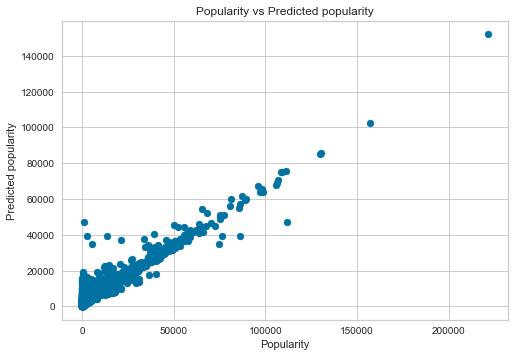

In [40]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, train_pred)
plt.xlabel("Popularity")
plt.ylabel("Predicted popularity")
plt.title("Popularity vs Predicted popularity")
plt.show()

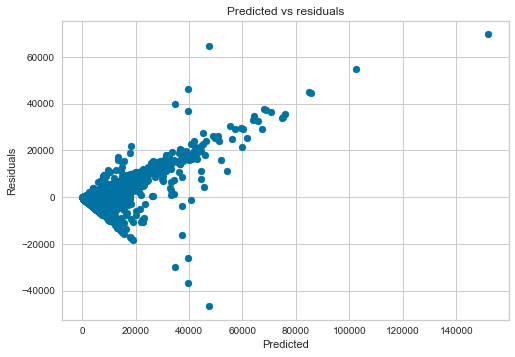

In [41]:
# Checking residuals
plt.scatter(train_pred,y_train-train_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

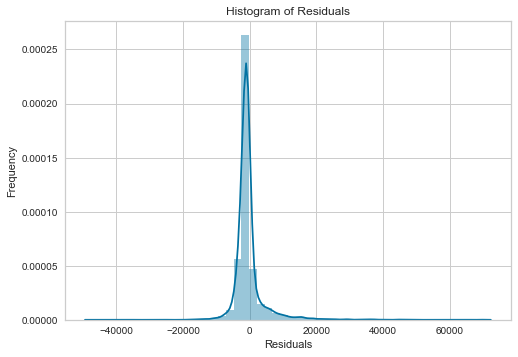

In [42]:
# Checking Normality of errors
sns.distplot(y_train-train_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

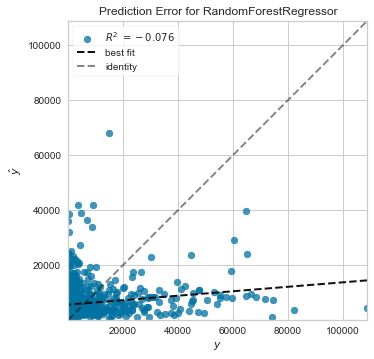

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [43]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(rf_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

#### 3. Lasso Regression

In [44]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 6388.927109882322
MSE: 128953138.31233971
RMSE: 11355.75353344461
R2 Square 0.04003625960939616
__________________________________
Train set evaluation:
_____________________________________
MAE: 6325.4852380810935
MSE: 147856206.4048182
RMSE: 12159.61374406351
R2 Square 0.03627753080788132
__________________________________


#### 4. Elastic Net

In [45]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 6359.636386830688
MSE: 128348281.34683517
RMSE: 11329.09004937445
R2 Square 0.04453898643408705
__________________________________
Train set evaluation:
_____________________________________
MAE: 6282.021520701209
MSE: 146785489.23943377
RMSE: 12115.506148710163
R2 Square 0.04325643426767567
__________________________________


In [46]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6359.961746,1.283764e+08,11330.332192,0.044329,0.037863
1,Random Forest Regressor,7082.786155,1.445545e+08,12023.082898,-0.076105,0.000000
2,Lasso Regression,6388.927110,1.289531e+08,11355.753533,0.040036,0.037879
3,Elastic Net Regression,6359.636387,1.283483e+08,11329.090049,0.044539,0.028449


From all of regression algorithms that we tried, random forest regressor turns out to be the best among all of them even though the error rate still remains high and R-squared is still low, which means that the model is not a good fit for now. However, for the next steps, we'll try to focus on lowering the error rate by doing some hyperparameter tuning using random forest regressor since all the linear methods didn't give us satisfying results. And, we'd also like to try popularity classification in the upcoming weeks.